In [1]:
import json
import sys
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.ticker as mtick

sys.path.append("architecture/")
from NormalizedMeanSquaredError import NormalizedMeanSquaredError as NMSE
from NormalizedMeanSquaredError import NormalizedMeanSquaredError2D as NMSE2

In [2]:
expt_name = 'S2-NLSL2-Expt1-L20-a'
data_file_prefix = 'data/S2-NLSL2'

In [3]:
save_prefix = 'results/{}/'.format(expt_name)
results_path = save_prefix + "initial_pool_results.json"
init_results = json.load(open(results_path))

In [4]:
lr = init_results['lr']
best_loss = init_results['best_loss']

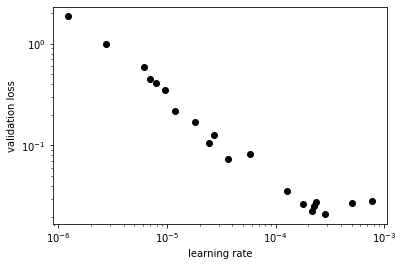

In [5]:
plt.figure()
plt.loglog(lr, best_loss, 'ok')
plt.xlabel('learning rate')
plt.ylabel('validation loss')
plt.show()

In [6]:
# Step 1. Load in the data
data_train_u = np.load("{}_train1_u.npy".format(data_file_prefix)).astype(np.float32)
data_train_f = np.load("{}_train1_f.npy".format(data_file_prefix)).astype(np.float32)
data_val_u = np.load("{}_val_u.npy".format(data_file_prefix)).astype(np.float32)
data_val_f = np.load("{}_val_f.npy".format(data_file_prefix)).astype(np.float32)
data_test_u1 = np.load("{}_test1_u.npy".format(data_file_prefix)).astype(np.float32)
data_test_f1 = np.load("{}_test1_f.npy".format(data_file_prefix)).astype(np.float32)
data_test_u = np.load("{}_test2_u.npy".format(data_file_prefix)).astype(np.float32)
data_test_f = np.load("{}_test2_f.npy".format(data_file_prefix)).astype(np.float32)

In [7]:
best_model_path = save_prefix + "final_model"

# Load the best model
full_model = keras.models.load_model(best_model_path, 
                                     custom_objects={"NormalizedMeanSquaredError": NMSE})


In [8]:
loss_fns = 4*[NMSE()]
predicted_ys = full_model.predict(x=[data_train_u, data_train_f])

true_ys=[data_train_u, data_train_f, data_train_f, data_train_u]
nmse = NMSE()

total_loss = 0
for i, (pred_y, true_y, loss_fn) in enumerate(zip(predicted_ys, true_ys, loss_fns)):
    #print(pred_y.dtype, true_y.dtype)
    print("Score {}:".format(i+1), end="  ")
    loss = loss_fn(pred_y, true_y)
    tf.print(loss)
    total_loss += loss
    
print(data_train_u.shape)
print("Total Loss:", total_loss)

Score 1:  0.000166488913
Score 2:  0.000240425652
Score 3:  0.00511120586
Score 4:  0.000855285907
(8836, 128)
Total Loss: tf.Tensor(0.0063734064, shape=(), dtype=float32)


In [9]:
val_x = [data_val_u, data_val_f]
val_ys = [data_val_u, data_val_f, data_val_f, data_val_u]
predicted_ys = full_model.predict(x=val_x)

total_loss = 0
for i, (pred_y, true_y) in enumerate(zip(predicted_ys, val_ys)):
    #print(pred_y.dtype, true_y.dtype)
    print("Score {}:".format(i), end="  ")
    loss = NMSE()(pred_y, true_y)
    tf.print(loss)
    total_loss += loss
    
print(data_val_u.shape)
print("Total Loss:", total_loss)

Score 0:  0.000221253111
Score 1:  0.000387275562
Score 2:  0.0132881692
Score 3:  0.0090101324
(2210, 128)
Total Loss: tf.Tensor(0.02290683, shape=(), dtype=float32)


In [10]:
losses = full_model.evaluate(x=val_x, y=val_ys, batch_size=64, return_dict=True)

35/35 [==============================] - 0s 4ms/step - loss: 0.0122 - output_1_loss: 2.1744e-04 - output_2_loss: 3.7444e-04 - output_3_loss: 0.0085 - output_4_loss: 7.2849e-04


In [11]:
full_model.summary()

Model: "green_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_encoder_decoder (Dense multiple                  82560     
_________________________________________________________________
dense_encoder_decoder_1 (Den multiple                  82560     
_________________________________________________________________
dense_encoder_decoder_2 (Den multiple                  82560     
_________________________________________________________________
dense_encoder_decoder_3 (Den multiple                  82560     
Total params: 340,880
Trainable params: 340,880
Non-trainable params: 0
_________________________________________________________________


In [12]:
results_path = save_prefix + "final_model_history.json"
f_hist = json.load(open(results_path))

In [13]:
np.min(f_hist['val_loss'])

0.012198429554700851

In [14]:
def rel_mse(pred, true, den_nonzero=1e-5):
    num = np.mean(np.square(pred-true), axis=-1)
    den = np.mean(np.square(true), axis=-1)
    den += den_nonzero
    return np.divide(num, den) 
    

In [15]:
val_x = [data_val_u, data_val_f]
val_ys = [data_val_u, data_val_f, data_val_f, data_val_u]
predicted_ys = full_model.predict(x=val_x)

data = []
total_loss = 0
for i, (pred_y, true_y) in enumerate(zip(predicted_ys, val_ys)):
    #print(pred_y.dtype, true_y.dtype)
    print("Score {}:".format(i), end="  ")
    data.append(rel_mse(pred_y, true_y, 1e-5))
    loss = np.mean(data[i])
    tf.print(loss)
    total_loss += loss

print("Total Loss:", total_loss)

Score 0:  0.00021744226
Score 1:  0.00037444066
Score 2:  0.008509359
Score 3:  0.0007284899
Total Loss: 0.00982973212376237


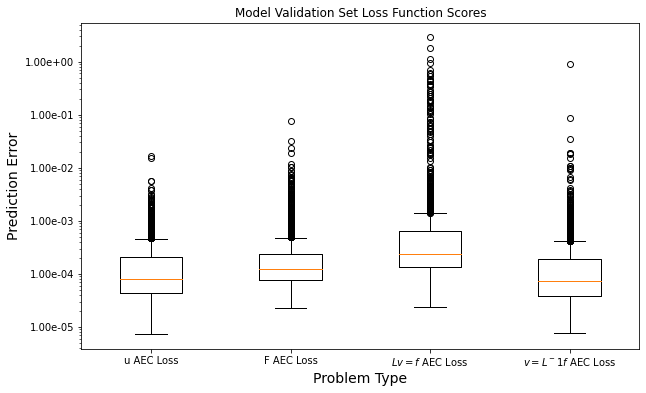

In [16]:
probs = ["u AEC Loss", "F AEC Loss", r"$Lv=f$ AEC Loss", r"$v=L^-1f$ AEC Loss"]

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_title(r'Model Validation Set Loss Function Scores')
ax.set_ylabel("Prediction Error", fontsize=14)
ax.set_xlabel("Problem Type", fontsize=14)
ax.boxplot(data, labels=probs, showfliers=True)
#ax.ticklabel_format(axis='y', style='sci')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.show()